# Does crime really increase in the summer?

I was talking to someone about crime frequency and what affects it, and they offhandedly remarked that it's common knowledge that there's more crime in the summer. I thought that could make sense, because the pleasant nighttime temperatures could lead to more people outside at night and therefore more crimes of opportunity taking place under the cover of darkness. On the other hand, there are fewer nighttime hours overall, and on top of that, more people outside at night could mean more witnesses and hence a deterrent to crime.

I imagine the answer to the question could be different depending on which city/country/neighborhood you're looking at, but I have here computed the answer for Seattle, based on the data at https://data.seattle.gov/Public-Safety/Seattle-Police-Department-Police-Report-Incident/7ais-f98f, which covers about 10 years.

#### Spoiler alert: actually, overall crime in Seattle decreases in the summer. 

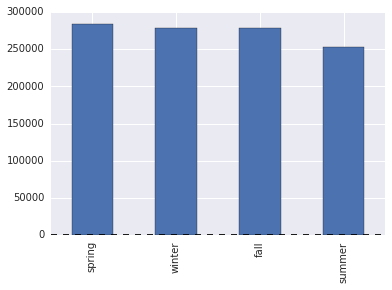

In [120]:
df['Season'].value_counts().plot(kind='bar')

# Analysis summary

In order to do a concrete analysis, I rephrased the above question as "Is the average number of crimes on a summer day greater than or less than the average number of crimes on a non-summer day?" and considered the number of crimes in each day in the data set as one sample value. Then I split the sample values into 

1. the set of the number of crimes each summer day, and
2. the set of the number of crimes each non-summer day.

[Side note: It turns out there are various definitions of summer (meteorological, astronomical, ...) so I went with the easiest one: I defined summer to mean the months of June, July, and August.]

It turned out that on average, a summer day in Seattle has about 16 FEWER crimes than a non-summer day (232 vs. 248). My instinct said that this was a pretty big gap, and considering the sample size, is pretty strong evidence indicating a drop in crime during the summer months. But my instincts have been wrong from time to time (some people might even use the word "often") so I calculated the probability of this difference in sample means given that the underlying distributions for crimes per day is the same for summer as for non-summer days. It turned out it was pretty small, so in this instance my instincts were justified :)

# Full analysis

In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn
import os.path
import requests
import re

from sklearn.utils import resample

%matplotlib inline

In [36]:
seattle_police_report_file = 'data/Seattle_Police_Department_Police_Report_Incident.csv'
if not os.path.exists(seattle_police_report_file):
    response = requests.get('https://data.seattle.gov/api/views/7ais-f98f/rows.csv?accessType=DOWNLOAD')
    with open(seattle_police_report_file,'w') as f:
        f.write(response.content)

In [37]:
df = pd.read_csv(seattle_police_report_file, 
    parse_dates=[7,8,9]
)

For simplicity let's say

* Spring runs from March 1 to May 31;
* Summer runs from June 1 to August 31;
* Fall (autumn) runs from September 1 to November 30; and
* Winter runs from December 1 to February 28 (February 29 in a leap year)

(taken from https://www.timeanddate.com/calendar/aboutseasons.html).

In [29]:
def to_season(month):
    if month in [3,4,5]: return 'spring'
    if month in [6,7,8]: return 'summer'
    if month in [9,10,11]: return 'fall'
    if month in [12,1,2]: return 'winter'

In [30]:
df['Season'] = df['Month'].apply(to_season)

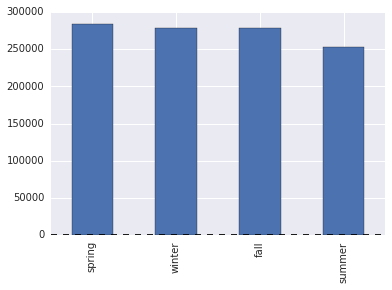

In [121]:
df['Season'].value_counts().plot(kind='bar')

Hm, doesn't look like it so far!

## Difference in average crimes per day

Hmm, it looks like overall crime might be lower in the summer. Let's see what the average number of crimes per day is on a summer day versus a non-summer day.

In [37]:
df['Date'] = df['Occurred Date or Date Range Start'].dt.date

In [54]:
daily_crime_count = df[['Date','RMS CDW ID']].groupby('Date').agg('count').reset_index(level=0).rename(columns={'RMS CDW ID':'CrimeCount'})

In [55]:
daily_crime_count.head()

,Date,CrimeCount
0,1965-01-10,2
1,1983-01-01,1
2,1983-02-23,2
3,1989-01-01,1
4,1990-01-01,1


In [58]:
daily_crime_count['Season'] = pd.to_datetime(daily_crime_count['Date']).dt.month.apply(to_season)

In [59]:
daily_crime_count.head()

,Date,CrimeCount,Season
0,1965-01-10,2,winter
1,1983-01-01,1,winter
2,1983-02-23,2,winter
3,1989-01-01,1,winter
4,1990-01-01,1,winter


In [103]:
avg_summer = daily_crime_count.loc[daily_crime_count['Season'] == 'summer']['CrimeCount'].mean()
avg_nonsummer = daily_crime_count.loc[daily_crime_count['Season'] != 'summer']['CrimeCount'].mean()
actual_diff = avg_nonsummer - avg_summer

In [104]:
print avg_summer
print avg_nonsummer
print actual_diff

232.411710887
248.510920897
16.0992100098


## Test for significance

The high-level question is "What is the probability that we arrive at this result by chance given that there is no difference in the actual mean of the two populations?"

Specifically, what is the probability that the summer mean is at least "actual_diff" less than the nonsummer mean?

We have to

1. Resample (with replacement) from the full set (summer + nonsummer) of daily crime counts
    1. One set same size as summer
    2. One set same size as nonsummer   
2. Compute the difference of their means (nonsummer - summer).
3. Repeat a lot of times.
4. See what proportion of the time the difference is greater than or equal to "actual_diff".

In [92]:
nSummer = (daily_crime_count['Season'] == 'summer').sum()
nNonSummer = len(daily_crime_count) - nSummer

In [97]:
nTrials = 10000
all_samples = np.array(daily_crime_count['CrimeCount'])
differences = np.zeros(nTrials)
for t in range(nTrials):
    summer_samples    = resample(all_samples, n_samples=nSummer)
    nonsummer_samples = resample(all_samples, n_samples=nNonSummer)
    differences[t] = nonsummer_samples.mean() - summer_samples.mean()

A beautiful example of the central limit theorem in action:

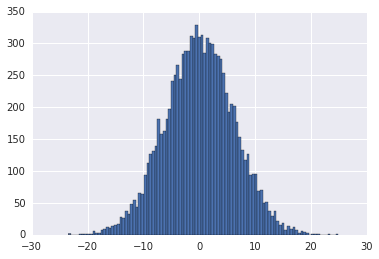

In [122]:
pd.Series(differences).hist(bins=100)

So what proportion of the time was the difference bigger than actual_difference?

In [102]:
(differences >= actual_diff).mean()

0.0051999999999999998

## Results

So in Seattle, there are on average 16 fewer crimes per day during the summer as compared to the rest of the year.
And I calculated that there is only a 0.5% probability that this difference is due to pure chance rather than an actual difference between crime rates.
So we can safely conclude that in Seattle, at least, there are fewer crimes in the summer.

# Bonus: time of day

I am (and perhaps you are) wondering if there is more crime at night during the summer, as I suspected. We can look at the average crime count per hour for summer days versus non-summer days to get a sense of this.

In [135]:
df['Hour'] = df['Occurred Date or Date Range Start'].dt.hour
df['Summer'] = df['Season'].apply(lambda s: s if s == 'summer' else 'not summer')

In [136]:
temp = df[['Summer','Hour','Date','RMS CDW ID']].groupby(
    ['Summer','Hour','Date']).size().reset_index().groupby(
    ['Summer','Hour']).mean().rename(columns={0:'AvgCrimeCount'}).reset_index() #/.plot(kind='bar')

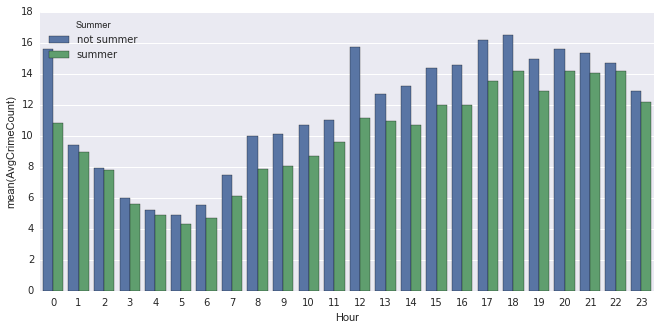

In [143]:
fig, ax = plt.subplots()
# the size of A4 paper
fig.set_size_inches(11, 5)
seaborn.barplot(x='Hour',y='AvgCrimeCount',hue='Summer',data=temp)

It looks like on average crime counts are roughly the same across the year during night time hours, but that daytime crime is lower in the summer. Who knew? Also there's a mysterious spike in crime at midnight and noon for the nonsummer days that isn't occurring for the summer days. That's weird. I also feel like we should be keeping in mind that some crimes aren't discovered immediately, so these results could be skewed by delays in reporting somehow.